In [15]:
"""Model a ball of gas with a polytropic equation of state."""

import warnings

import numpy as np
import astropy.constants as const
import astropy.units as u
from astropy.table import QTable
from scipy.integrate import solve_ivp

class Polytrope:
    """Model with a polytropic equation of state.
    P = K ρˠ
    Here, the polytropic exponent γ is related to the polytropic
    index n by γ = 1 + 1/n.
    Parameters
    ----------
    K : `~astropy.units.Quantity`
        Proportionality constant.  Should have appropriate units.
    gamma : float
        Polytropic exponent.
    """

    def __init__(self, k, gamma):
        self.k = k
        self.gamma = gamma
        self._rho_c = None
        self._r_unit = None
        self._condition = None
        self._mr_scale = None
#         self.result = None


    def integrate(self, rho_c, r, condition=None):
        """Integrate MC and HE from a given starting density.
        Parameters
        ----------
        rho_c : `~astropy.units.Quantity`
            Central density to start integration at.
        r : `~astropy.units.Quantity`
            Radii at which to evaluate the integral.  Radii beyond the
            stopping condition will not be used.
        condition : callable, optional
            Function that tells when to stop integrating.  Will be pass on
            ``r, mr, rho`` and should return a value that changes sign when
            the integration should stop. By default, uses the density, i.e.,
            integration will stop once the density becomes negative.
        Returns
        -------
        result : `~astropy.table.QTable`
            A table with columns ``r, mr, rho, p`` evaluated at the given
            radii, as well as at the location where the integration stopped
            (if that was within the range of input radii).
        """
        self._rho_c = rho_c
        self._r_unit = r.unit
        self._condition = condition
        # It is easier to integrate with variables of the same order
        # of magnitude, so work relative to rho_c and an estimate
        # of the total mass (not critical to have it exactly right).
        self._mr_scale = (self._rho_c * (r.max() / 2) ** 3).to(u.Msun)
        # scipy integration routine cannot handle Quantity, so use
        # scaled values and multiply with scales as needed in .structure_eqs().
        
        sol = solve_ivp(
            self.structure_eqs,  # Function that calculates derivatives.
            t_span=r[[0, -1]].value,  # Range within which to integrate.
            y0=[0, 1],  # Initial values: Mr=0, rho/rho_c=1.
            t_eval=r.value,  # Evaluate at chosen points.
            events=self.terminate,  # Terminate when ρ<0 (or condition < 0).
        )
        if not sol.success:
            warnings.warn('Solver did not succeed.')
        # Put physical scales back on.
        r_sol = sol.t * self._r_unit
        mr = sol.y[0] * self._mr_scale
        rho = sol.y[1] * self._rho_c
        result = QTable([r_sol, mr, rho], names=['r', 'mr', 'rho'])
        if len(sol.t_events[0]):
            # If density got to 0, add a final row for that.
            assert len(sol.t_events) == 1 and len(sol.t_events[0]) == 1
            result.insert_row(
                len(result),
                dict(r=sol.t_events[0][0] * self._r_unit,
                     mr=sol.y_events[0][0, 0] * self._mr_scale,
                     rho=max(sol.y_events[0][0, 1], 0) * self._rho_c))
        # Add column with implied pressure (from polytropic EoS).
        result['p'] = (self.k * result['rho']**self.gamma).to(u.Pa)
        t = mu * const.m_p * result['p'] / (result['rho'] * const.k_B)
        result['energy'] = self.energy_eq(result['rho'],t)
        return result

    def structure_eqs(self, r, par):
        """Mass conservation and hydrostatic equilibrium (for internal use).
        dMᵣ/dr = 4πr²ρ
        dP/dr = -GMᵣρ/r²
        Latter transformed to dρ/dr by getting dP/dρ from EoS.
        Parameters
        ----------
        r : float
            Radius in units of ``self._r_unit``.
        par : list of float
            Current parameters: scaled enclosed mass and density.
        Returns
        -------
        derivatives : list of float
            Derivatives of scaled enclosed mass and density with radius.
        """
        if r == 0 or par[1] <= 0:
            return [0, 0]
        # Multiply with physical scale/uit.
        r = r * self._r_unit
        mr = par[0] * self._mr_scale
        rho = par[1] * self._rho_c
        # Mass conservation.
        dmr_dr = 4 * np.pi * r**2 * rho
        # Hydrostatic equibrium, use in terms of density.
        dp_dr = -const.G * mr / r**2 * rho
        # For polytropic equation of state, dP/dρ=γKρˠ⁻¹.
        dp_drho = self.k * rho ** (self.gamma - 1.) * self.gamma
        drho_dr = dp_dr / dp_drho
        # Temperature for energy equation
        
        # Bring back to correct unit and return just the values.
        return [(dmr_dr / self._mr_scale).to_value(1 / self._r_unit),
                (drho_dr / self._rho_c).to_value(1 / self._r_unit)]

    def terminate(self, r, par):
        """Stopping condition (for internal use).
        Returns the scaled density if no explicit ``condition`` was used in
        the call to ``integrate()``.  Otherwise, calls ``condition`` with
        ``r, mr, rho`` in physical units.
        Parameters
        ----------
        r : float
            Radius in units of ``self._r_unit``.
        par : list of float
            Current parameters: scaled enclosed mass and density.
        Returns
        -------
        value : float
            The value which, if it changes sign, signals that integration
            should stop.
        """
        if self._condition is None:
            # By default, just terminate if the density becomes less than 0.
            return par[1]

        condition = self._condition(
            r,
            mr=par[0]*self._mr_scale,
            rho=par[1]*self._rho_c
        )
        # Cannot pass back units, so get the number for any quantity output.
        return getattr(condition, 'value', condition)

    # Signal to solve_ivp to stop integration if the termination signal
    # changes sign.

    def energy_eq(self, rho, T):
        """KWW Eq.18.63. Written by Shuhan Zheng"""
        edkt = 5.92 * 10 **-3 * (rho/T**3)**0.5
        X = 1 # Kept as 1 because we are assuming ideal
        f_gg = np.exp(edkt)
        g_11 = 1 + 0.0123 * T**(1/3) + 0.0109 * T**(2/3) + 0.0009 * T
        e_pp = 2.38 * 10**6 * f_gg * g_11 * rho * X**2 * np.exp(-33.80 * T**(-1/3))

        return e_pp

    terminate.terminal = True

In [16]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
from simple_star.polytrope import Polytrope

### 0.3 M-sun, 0.33 R-sun

In [17]:
m = 0.3*u.M_sun
r = 0.33*u.R_sun
mu = 1/2  # 70% molecular hydrogen, 30% Helium+heavier
rho_c = 5.99071*m / (4/3*np.pi*r**3).si
pc = 0.77014*const.G*m**2/r**4 # Ideal gas law
gamma = 5/3 # Since n=1.5
k = pc / (rho_c ** gamma).si
print(k)
poly = Polytrope(k=k, gamma=gamma)
p_ism = 2.5e-12 * u.Pa


def p_gt_p_ism(r, mr, rho):
    return k*rho**gamma - p_ism

result1 = poly.integrate(rho_c, np.linspace(0, 0.33, 201)*u.R_sun,
                        condition=p_gt_p_ism)

3.242005766720285e-18 m8 solMass2 / (kg(8/3) s2 solRad4)


Text(0.5, 0, '$r\\ [R_\\odot]$')

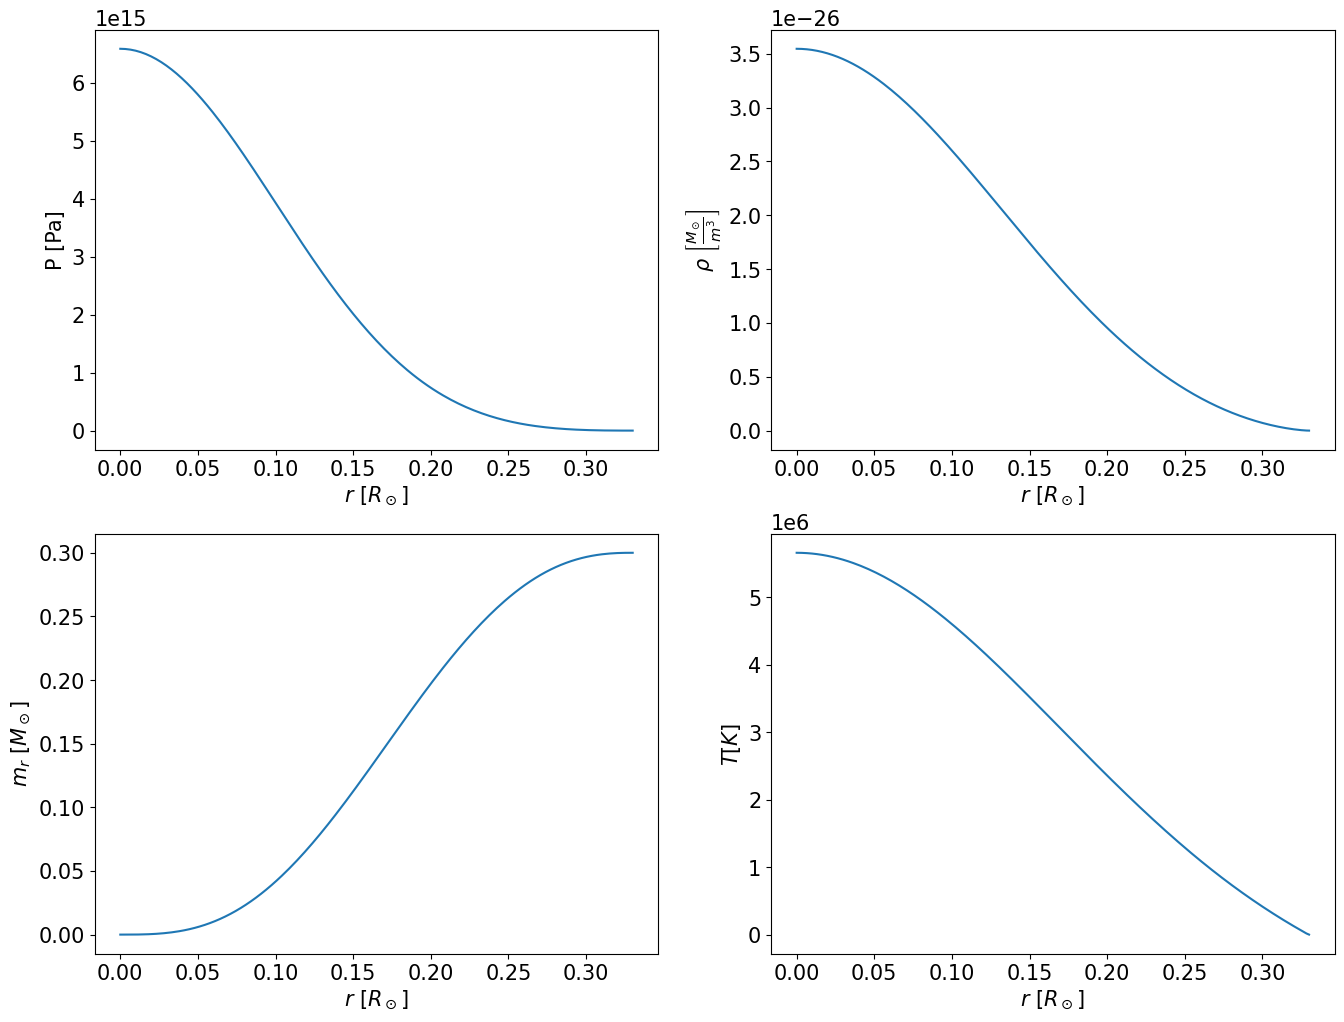

In [18]:
# x_ideal = rho/(mu m_H) * kT/P
# So T = x_ideal * mu * m_H * P / (rho * k)
# Let x_ideal = 1
T1 = mu * const.m_p * result1["p"] / (result1["rho"] * const.k_B)
T1 = T1.si

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2,2, figsize=(16,12))
ax[0][0].plot(result1["r"], result1["p"])
ax[0][0].set_xlabel(r'$r\ [R_\odot]$')
ax[0][0].set_ylabel('P [Pa]')
ax[0][1].plot(result1["r"], result1["rho"])
ax[0][1].set_ylabel(r'$\rho\ \left[\frac{M_\odot}{m^{3}}\right]$')
ax[0][1].set_xlabel(r'$r\ [R_\odot]$')
ax[1][0].plot(result1["r"], result1["mr"])
ax[1][0].set_ylabel(r'$m_r\ [M_\odot]$')
ax[1][0].set_xlabel(r'$r\ [R_\odot]$')
ax[1][1].plot(result1["r"], T1)
ax[1][1].set_ylabel(r'$T [K]$')
ax[1][1].set_xlabel(r'$r\ [R_\odot]$')

In [19]:
result1["p"][0]

<Quantity 6.58394147e+15 Pa>

In [20]:
T1[0].si

<Quantity 5656677.83939945 K>

In [21]:
np.log10(1.91*10**7)

7.281033367247727

In [22]:
result1

r,mr,rho,p
solRad,solMass,solMass / m3,Pa
float64,float64,float64,float64
0.0,0.0,3.545709184740214e-26,6583941471198816.0
0.00165,2.247109827012924e-07,3.5454134065807386e-26,6583026124489567.0
0.0033,1.7980602602151765e-06,3.544526624487092e-26,6580282098948604.0
0.0049499999999999995,6.065982380831066e-06,3.543048860654501e-26,6575710378241820.0
0.0066,1.437047465501729e-05,3.540980400982467e-26,6569313371412291.0
0.00825,2.804976389450796e-05,3.538322080292748e-26,6561095792651050.0
0.009899999999999999,4.8438306412302994e-05,3.535075282329362e-26,6551064655716092.0
0.01155,7.68663679374316e-05,3.531241935263184e-26,6539229251820456.0


### 0.1 M-sun, 0.13 R-sun

In [8]:
m = 0.1*u.M_sun
r = 0.13*u.R_sun
mu = 4/3  # 70% molecular hydrogen, 30% Helium+heavier
rho_c = 5.99071*m / (4/3*np.pi*r**3).si
pc = 0.77014*const.G*m**2/(r**4) # Ideal gas law
gamma = 5/3 # Since n=3
k = pc / (rho_c ** gamma).si
print(k)
poly = Polytrope(k=k, gamma=gamma)
p_ism = 2.5e-12 * u.Pa


def p_gt_p_ism(r, mr, rho):
    return k*rho**gamma - p_ism

result2 = poly.integrate(rho_c, np.linspace(0, 0.13, 201)*u.R_sun,
                        condition=p_gt_p_ism)

8.85528977219657e-19 m8 solMass2 / (kg(8/3) s2 solRad4)


/opt/conda/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0, '$r\\ [R_\\odot]$')

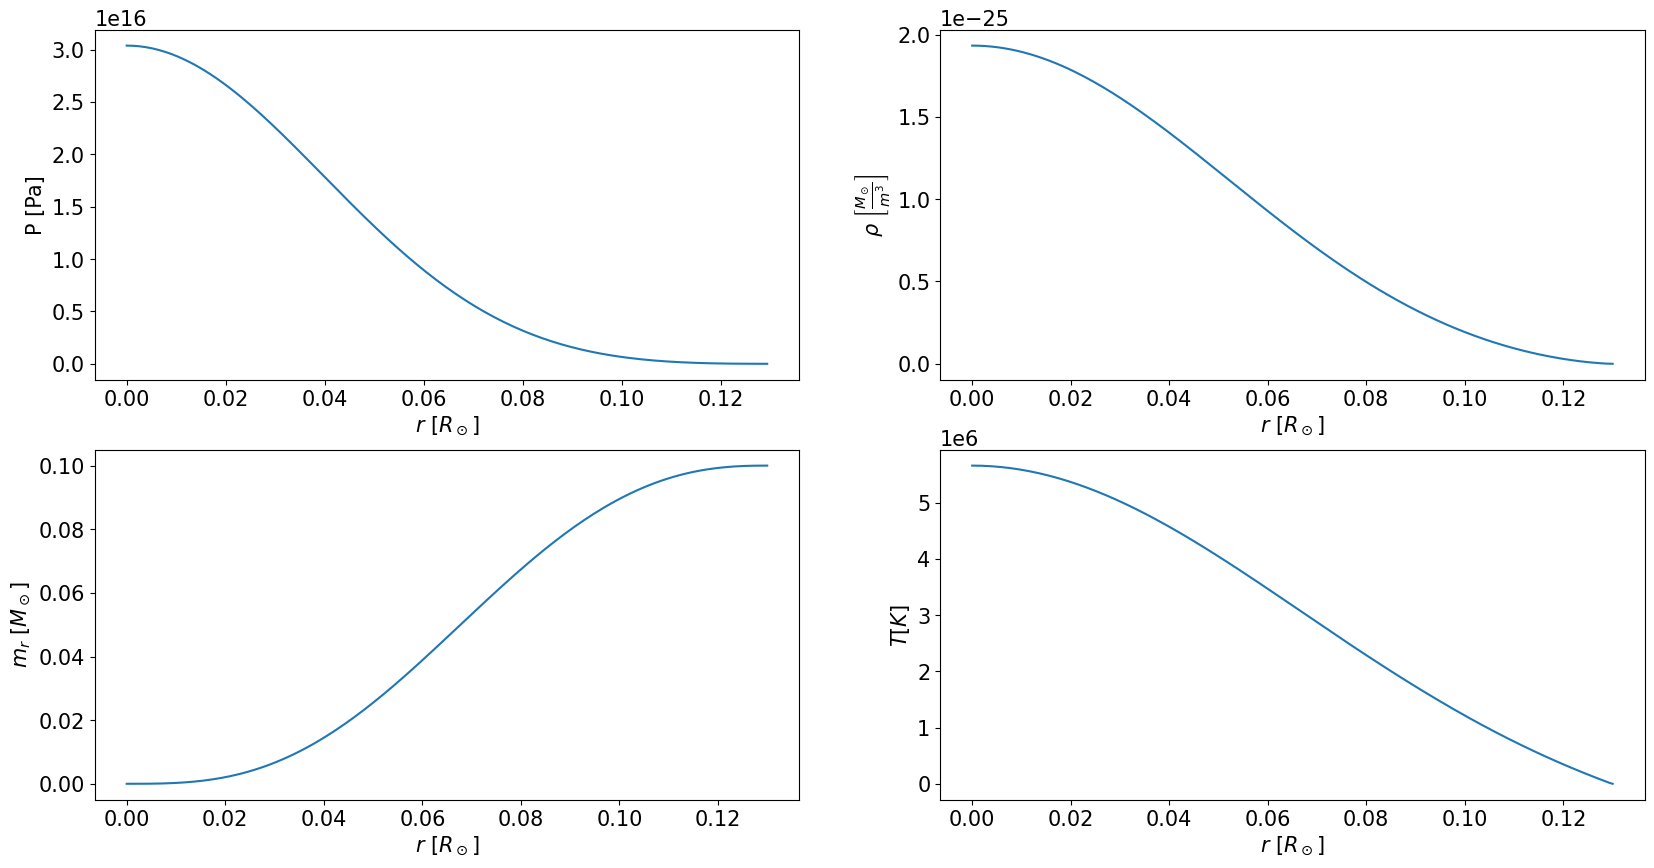

In [9]:
T2 = mu * const.m_p * result2["p"] / (result2["rho"] * const.k_B)
T2 = T2.si
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0][0].plot(result2["r"], result2["p"])
ax[0][0].set_xlabel(r'$r\ [R_\odot]$')
ax[0][0].set_ylabel('P [Pa]')
ax[0][1].plot(result2["r"], result2["rho"])
ax[0][1].set_ylabel(r'$\rho\ \left[\frac{M_\odot}{m^{3}}\right]$')
ax[0][1].set_xlabel(r'$r\ [R_\odot]$')
ax[1][0].plot(result2["r"], result2["mr"])
ax[1][0].set_ylabel(r'$m_r\ [M_\odot]$')
ax[1][0].set_xlabel(r'$r\ [R_\odot]$')
ax[1][1].plot(result2["r"], T1)
ax[1][1].set_ylabel(r'$T [K]$')
ax[1][1].set_xlabel(r'$r\ [R_\odot]$')

In [10]:
result2["p"][0]

<Quantity 3.03756655e+16 Pa>

In [11]:
T2[0].si

<Quantity 12763785.89402953 K>

In [12]:
np.log10(result2["rho"][0].si.to(u.g / u.cm ** 3).value)

2.584799530712714